In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import pickle as pkl
print("TF  Version",tf.__version__)

TF  Version 2.2.0


Using TensorFlow backend.


In [2]:
# check and set path before loading modules
INPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != OUTPUT_DIR:
    os.chdir(OUTPUT_DIR)
    
import functions_model_definition as md
import functions_read_data as rdat
#weights tuning functions
import ens_weights_tuning as w_tune
#ontram functions
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

In [3]:
# Define Version
version = "CIBLSX" # one of:
#version = "CIB" # one of:

# Define Model Version
model_version = 5

# Select naming convention (for CIBLSX model_version >= 3 should be False)
comp_mode = False # if True: use old naming convention

# define paths
DATA_DIR, WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    INPUT_DIR, OUTPUT_DIR, version, model_version, 
    compatibility_mode=comp_mode)

save_csv = False
## load images and ids
(X_in, pat_ids, id_tab, all_results_tab, pat_orig_tab, pat_norm_tab, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, 
    version = version, 
    model_version = model_version,
    compatibility_mode=comp_mode)
pat_norm_tab

Results Table does not exist for CIBLSX M5. Returning None for all_results_tab.


,p_id,age,sexm,nihss_baseline,stroke_beforey,tia_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,mrs_before_1,mrs_before_2,mrs_before_3,mrs_before_4
0,1,-2.196946,1,-0.657875,0,0,0,0,1,0,0,0,0,0,0,0
1,2,-1.407829,1,0.482720,0,0,0,0,1,0,0,0,0,0,0,0
2,3,0.893762,1,1.786257,0,0,1,1,1,1,1,0,0,0,0,0
3,5,0.828002,1,0.482720,0,0,0,1,0,0,1,0,1,0,0,0
4,6,1.222560,0,0.156836,0,0,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,555,0.900338,1,-0.494933,0,0,0,0,1,0,1,1,1,0,0,0
503,556,-1.684020,1,-0.820817,0,0,1,0,0,1,0,0,0,0,0,0
504,557,0.334804,0,-0.657875,0,0,0,0,1,0,0,0,0,0,0,0
505,559,0.347956,0,-0.494933,0,0,1,0,1,0,0,0,0,0,1,0


In [4]:
# define model
(input_dim_img, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.model_init(
    version = version, 
    output_dim = output_dim,
    LOSS = LOSS,
    layer_connection = layer_connection,
    last_activation = last_activation,
    C = 2,
    learning_rate = 5*1e-5,
    batch_size = 6,
    input_dim = input_dim_img,
    input_dim_tab = pat_norm_tab.drop(columns=["p_id"]).shape[1] if "LSX" in version else None,
)

In [5]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR,
    compatability_mode=comp_mode)  

In [6]:
model_nrs = list(range(5)) #num of ensembles
which_splits = list(range(0,10)) # 10 Fold

In [7]:
results_list = [] 
valid_list = [] 
weights = []
betas = []

for which_split in which_splits:
    data_split = rdat.split_data(id_tab, X_in, which_split, X_tab = pat_norm_tab)

    X_valid = np.expand_dims(data_split["X"]["valid"], axis=-1)
    X_test = np.expand_dims(data_split["X"]["test"], axis=-1)
    Y_valid = to_categorical(data_split["y"]["valid"])
    Y_test = to_categorical(data_split["y"]["test"])

    if pat_norm_tab is not None:
        X_tab_test = data_split["X_tab"]["test"]    
        X_tab_valid = data_split["X_tab"]["valid"]
        test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
        valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
        shift_params = []
    else:
        X_tab_test = None
        X_tab_valid = None
        test_data = tf.data.Dataset.from_tensor_slices((X_test))
        valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
        shift_params = None

    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  

    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()       
    results["test_split"] = which_split        
        
    validation_results = pd.DataFrame(
            {"test_split": which_split,
            "unfavorable": data_split["y"]["valid"]})
      
    y_test_preds = []
    y_valid_preds = []   
    intercepts_test = []
    intercepts_val = []
    
    for model_nr in model_nrs:
        model_3d.load_weights(generate_model_name(which_split, model_nr))

        #test
        predic = predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        # Save Intercepts for tuning
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

        # Save shift parameters if CIB_LSX
        if shift_params is not None:
            shift_params.append(get_parameters(model_3d)['shift'][0][0][0])       

    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds) 

    weigths_tuned = w_tune.get_w(intercepts = intercepts_val,
                             y_true = data_split["y"]["valid"],
                             shift = shift_params,
                             X_tab = X_tab_valid)
    
    for model_nr in model_nrs:
        results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]
        validation_results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]

    results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts = intercepts_test, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_test, 
                                                      weights=None)
    
    results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts = intercepts_test, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_test, 
                                                      weights=weigths_tuned)
    
    validation_results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts = intercepts_val, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_valid, 
                                                      weights=None) 
    
    validation_results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts = intercepts_val, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_valid, 
                                                      weights=weigths_tuned)
    
    results_list.append(results)
    valid_list.append(validation_results)
    betas.append(shift_params)
    weights.append(weigths_tuned)

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [8]:
valid_thresholds_avg = []
valid_thresholds_avg_w = []

for i, validation_results in enumerate(valid_list):
  
    y_org = validation_results["unfavorable"]
    y_pred_avg = validation_results["y_pred_trafo_avg"]
    y_pred_avg_w = validation_results["y_pred_trafo_avg_w"]
  
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred_avg)
    fpr_w, tpr_w, threshold_w = metrics.roc_curve(y_org, y_pred_avg_w)

    #auc
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_w = metrics.auc(fpr_w, tpr_w)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))
    gmean_w = np.sqrt(tpr_w * (1 - fpr_w))

    # Find the optimal threshold
    index = np.argmax(gmean)
    index_w = np.argmax(gmean_w)

    valid_thresholds_avg.append(threshold[index])
    valid_thresholds_avg_w.append(threshold_w[index_w])

### Apply Threshold to Testdata

In [9]:
for i, results in enumerate(results_list):
    results["threshold_avg"] = valid_thresholds_avg[i]
    results["threshold_avg_w"] = valid_thresholds_avg_w[i]
    
    results["y_pred_class_avg"] = (results["y_pred_trafo_avg"] >= results["threshold_avg"]).astype(int)
    results["y_pred_class_avg_w"] = (results["y_pred_trafo_avg_w"] >= results["threshold_avg_w"]).astype(int)

#### Concat all Pandas and Analyze

In [10]:
all_results = pd.concat(results_list)

## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [11]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

In [12]:
weighted_means = np.average(all_results[["y_pred_model_" + str(i) for i in range(5)]],
                            weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                            axis=1)

weighted_var = np.average((all_results[["y_pred_model_" + str(i) for i in range(5)]] - weighted_means[:, np.newaxis])**2,
                                         weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                                         axis=1)

all_results["y_pred_std_w"] = np.sqrt(weighted_var)

all_results["y_pred_unc_w"] = (all_results["y_pred_std_w"] - all_results["y_pred_std_w"].min()) / (
        all_results["y_pred_std_w"].max() - all_results["y_pred_std_w"].min())

In [13]:
all_results["pred_correct"] = all_results["y_pred_class_avg"] == all_results["unfavorable"] 
all_results["pred_correct_w"] = all_results["y_pred_class_avg_w"] == all_results["unfavorable"] 

# Save

In [16]:
if not comp_mode:
    res_name = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

elif comp_mode:
    res_name = DATA_DIR + "all_tab_results_10Fold_" + version + "_M" + str(model_version) + ".csv"

In [17]:
res_name

'/tf/notebooks/schnemau/xAI_stroke_3d/data/all_tab_results_CIBLSX_M5.csv'

In [19]:
if save_csv == True:
    all_results.to_csv(res_name,  index=False) 

# Plot Shift Parameters

In [18]:
if version == "CIBLSX":
    betas = np.array(betas)
    weights = np.array(weights)

    num_levels = 10 # axis 0
    num_sublevels = 5 # axis 1
    num_parameters = 15 # axis 2

    means_per_level = np.mean(betas, axis=1)

    means_per_level_w = []
    for i in range(betas.shape[0]):
        means_per_level_w.append(np.average(betas[i], axis=0, weights=weights[i]))
    means_per_level_w = np.array(means_per_level_w)

    means_per_parameter = means_per_level.transpose(1, 0, 2).reshape(num_parameters, num_levels)
    means_per_parameter_w = means_per_level_w.transpose(1, 0, 2).reshape(num_parameters, num_levels)

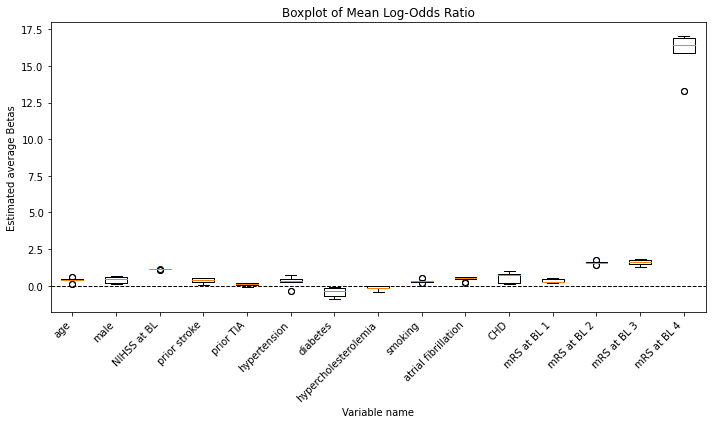

In [19]:
if version == "CIBLSX":
   
    variable_names = ["age", "male", "NIHSS at BL", "prior stroke", 
                    "prior TIA", "hypertension", "diabetes", "hypercholesterolemia", 
                     "smoking", "atrial fibrillation", "CHD", 
                    "mRS at BL 1", "mRS at BL 2", "mRS at BL 3", "mRS at BL 4"]

    # Plotting boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(means_per_parameter.T, labels=variable_names)
    plt.axhline(0, color='black', lw=1, linestyle='--')
    plt.title('Boxplot of Mean Log-Odds Ratio')
    plt.xlabel('Variable name')
    plt.ylabel('Estimated average Betas')
    plt.grid(False)  # Remove grid lines
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

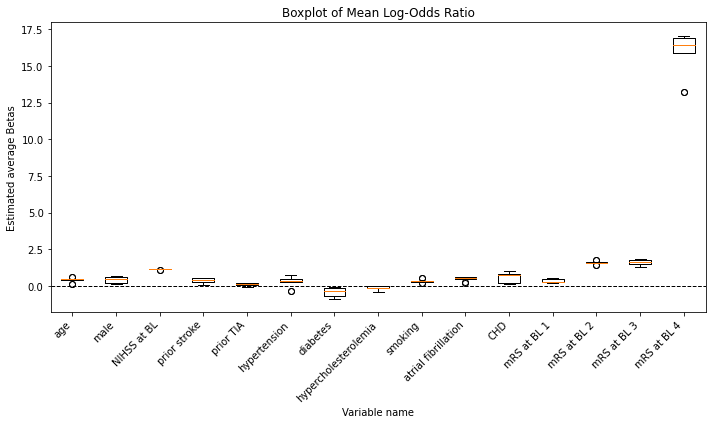

In [20]:
if version == "CIBLSX":
    variable_names = ["age", "male", "NIHSS at BL", "prior stroke", 
                    "prior TIA", "hypertension", "diabetes", "hypercholesterolemia", 
                     "smoking", "atrial fibrillation", "CHD", 
                    "mRS at BL 1", "mRS at BL 2", "mRS at BL 3", "mRS at BL 4"]

    # Plotting boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(means_per_parameter_w.T, labels=variable_names)
    plt.axhline(0, color='black', lw=1, linestyle='--')
    plt.title('Boxplot of Mean Log-Odds Ratio')
    plt.xlabel('Variable name')
    plt.ylabel('Estimated average Betas')
    plt.grid(False)  # Remove grid lines
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

In [21]:
import seaborn as sns

def plot_beta_values(coef_df): 

    df_reshaped = coef_df.melt(var_name='Variable', value_name='Value').reset_index().rename(columns={'index': 'model_nr'})
    df_reshaped['model_nr'] = df_reshaped['model_nr'] % len(coef_df)

    # Sort the dataframe by the highest mean of each variable
    df_sorted = df_reshaped.groupby('Variable')['Value'].mean().sort_values(ascending=False).index
    df_reshaped['Variable'] = pd.Categorical(df_reshaped['Variable'], categories=df_sorted, ordered=True)

    # Plotting boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        y = "Variable", 
        x = "Value",
        data = df_reshaped,
        color = "lightgrey",
        width = 0.5,
        )
    sns.stripplot(
        y = "Variable", 
        x = "Value",
        # hue = "model_nr",
        data = df_reshaped,
        color = "black",
        jitter=False,
        alpha = 0.75)
    plt.axvline(0, color='black', lw=1, linestyle='--')
    plt.title('Boxplot of weighted Log-Odds Ratio')
    plt.xlabel('Estimated weighted Betas')
    plt.ylabel('Variable')
    plt.yticks(ha='right')  # Rotate y-axis labels for better readability
    plt.tight_layout()
    plt.grid(axis = "x")
    plt.show()


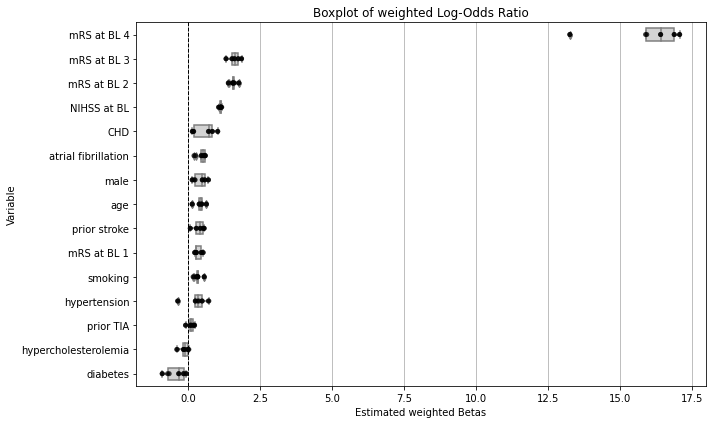

In [22]:
if version == "CIBLSX": 

    plot_beta_values(pd.DataFrame(means_per_parameter_w.T, columns=variable_names))

In [ ]:
from sklearn.linear_model import LogisticRegression

def fit_log_reg(x_train, y_train, oh_mrs_before = False, stand_oh_mrs_before = False):
    # x_train: pandas dataframe with training data
    # y_train: pandas series with target variable
    # oh_mrs_before: boolean, whether to one-hot encode mrs_before
    # stand_oh_mrs_before: boolean, whether to standardize one-hot encoded mrs_before (only relevant if oh_mrs_before is True)

    if oh_mrs_before:
        x_train = pd.get_dummies(x_train, columns=['mrs_before'], drop_first=True)

        x_train.rename(columns={
            'mrs_before_0.705288128801963': 'mrs_bl_1',
            'mrs_before_1.8815416857184': 'mrs_bl_2',
            'mrs_before_3.05779524263483': 'mrs_bl_3',
            'mrs_before_4.2340487995512595': 'mrs_bl_4'
        }, inplace=True)

        if stand_oh_mrs_before:
            x_train['mrs_bl_1'] = (x_train['mrs_bl_1'] - x_train['mrs_bl_1'].mean()) / x_train['mrs_bl_1'].std()
            x_train['mrs_bl_2'] = (x_train['mrs_bl_2'] - x_train['mrs_bl_2'].mean()) / x_train['mrs_bl_2'].std()
            x_train['mrs_bl_3'] = (x_train['mrs_bl_3'] - x_train['mrs_bl_3'].mean()) / x_train['mrs_bl_3'].std()
            x_train['mrs_bl_4'] = (x_train['mrs_bl_4'] - x_train['mrs_bl_4'].mean()) / x_train['mrs_bl_4'].std()

            print(x_train['mrs_bl_1'].mean(), x_train['mrs_bl_1'].std())


    logreg = LogisticRegression()

    # Fit the model to the training data
    logreg.fit(x_train, y_train)


    coef_names = x_train.columns
    coef_values = logreg.coef_[0]

    df = pd.DataFrame(np.expand_dims(coef_values, axis = 0), columns=coef_names)

    return (df, logreg.intercept_[0])


In [23]:
coefficients = []
coefficients_oh = []
coefficients_oh_stand = []
intercepts = []
intercepts_oh = []
intercepts_oh_stand = []

for which_split in which_splits:
    data_split = rdat.split_data(id_tab, X_in, which_split, X_tab = pat_norm_tab)

    tab_train = data_split["X_tab"]["train"]
    tab_train = pd.DataFrame(tab_train, columns = pat_norm_tab.drop(columns=["p_id"]).columns)
    y_train = data_split["y"]["train"]    

    log_fit = fit_log_reg(tab_train, y_train, oh_mrs_before = False)
    log_fit_oh = fit_log_reg(tab_train, y_train, oh_mrs_before = True)
    log_fit_oh_stand = fit_log_reg(tab_train, y_train, oh_mrs_before = True, stand_oh_mrs_before = True)

    coefficients.append(log_fit[0])
    coefficients_oh.append(log_fit_oh[0])
    coefficients_oh_stand.append(log_fit_oh_stand[0])
    intercepts.append(log_fit[1])
    intercepts_oh.append(log_fit_oh[1])
    intercepts_oh_stand.append(log_fit_oh_stand[1])
    

NameError: name 'fit_log_reg' is not defined

In [ ]:
plot_beta_values(pd.concat(coefficients))

In [ ]:
plot_beta_values(pd.concat(coefficients_oh))

In [ ]:
plot_beta_values(pd.concat(coefficients_oh_stand))

# Evaluation metrics

In [24]:
y_true = all_results["unfavorable"]
y_pred_binary = all_results["y_pred_class_avg"]
y_pred_binary_w = all_results["y_pred_class_avg_w"]

y_pred_trafo_avg = all_results["y_pred_trafo_avg"]
y_pred_trafo_avg_w = all_results["y_pred_trafo_avg_w"]

# Calculate metrics average weighted
f1_value = metrics.f1_score(y_true, y_pred_binary)
accuracy = metrics.accuracy_score(y_true, y_pred_binary)
sensitivity = metrics.recall_score(y_true, y_pred_binary)
specificity = metrics.recall_score(y_true, y_pred_binary, pos_label=0)
auc_value = metrics.roc_auc_score(y_true, y_pred_trafo_avg)
log_li = metrics.log_loss(y_true, y_pred_trafo_avg)

# Calculate metrics tuned weighted average
f1_value_w = metrics.f1_score(y_true, y_pred_binary_w)
accuracy_w = metrics.accuracy_score(y_true, y_pred_binary_w)
sensitivity_w = metrics.recall_score(y_true, y_pred_binary_w)
specificity_w = metrics.recall_score(y_true, y_pred_binary_w, pos_label=0)
auc_value_w = metrics.roc_auc_score(y_true, y_pred_trafo_avg_w)
log_li_w = metrics.log_loss(y_true, y_pred_trafo_avg_w)

# Display results 1
print("---Trafo Average:---")
print("F1-Value:", round(f1_value,4))
print("Accuracy:", round(accuracy,4))
print("Sensitivity:", round(sensitivity,4))
print("Specificity:", round(specificity,4))
print("AUC:", round(auc_value,4))
print("Negative Log-Likelihood:", round(log_li,4))

print("---------------------------------------------")

# Display results 2
print("---Trafo Average weighted tuned:---")
print("F1-Value:", round(f1_value_w,4))
print("Accuracy:", round(accuracy_w,4))
print("Sensitivity:", round(sensitivity_w,4))
print("Specificity:", round(specificity_w,4))
print("AUC:", round(auc_value_w,4))
print("Negative Log-Likelihood:", round(log_li_w,4))

---Trafo Average:---
F1-Value: 0.4839
Accuracy: 0.7641
Sensitivity: 0.6
Specificity: 0.8012
AUC: 0.799
Negative Log-Likelihood: 0.4007
---------------------------------------------
---Trafo Average weighted tuned:---
F1-Value: 0.4842
Accuracy: 0.7592
Sensitivity: 0.6133
Specificity: 0.7922
AUC: 0.7985
Negative Log-Likelihood: 0.3947


In [25]:
import functions_metrics as fm
fm.bin_class_report_ontram(y_true, y_pred_binary_w, y_pred_trafo_avg_w)

Performance on Test Set : 

Accuracy    [95% Conf.] : 0.7592 [0.7154 0.7982]
Sensitivity [95% Conf.] : 0.6133 [0.5002 0.7154]
Specificity [95% Conf.] : 0.7922 [0.7453 0.8324]
F1 Score [95% Conf.] : 0.4842 [0.3933 0.5668]
Area under Curve (AUC) Binary [95% Conf.]: 0.7028 [0.6418 0.7612]
Area under Curve (AUC) Probability [95% Conf.]: 0.7985 [0.7367 0.8551]
Negative Log-Likelihood : 0.3947 [0.323  0.4712]


# Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


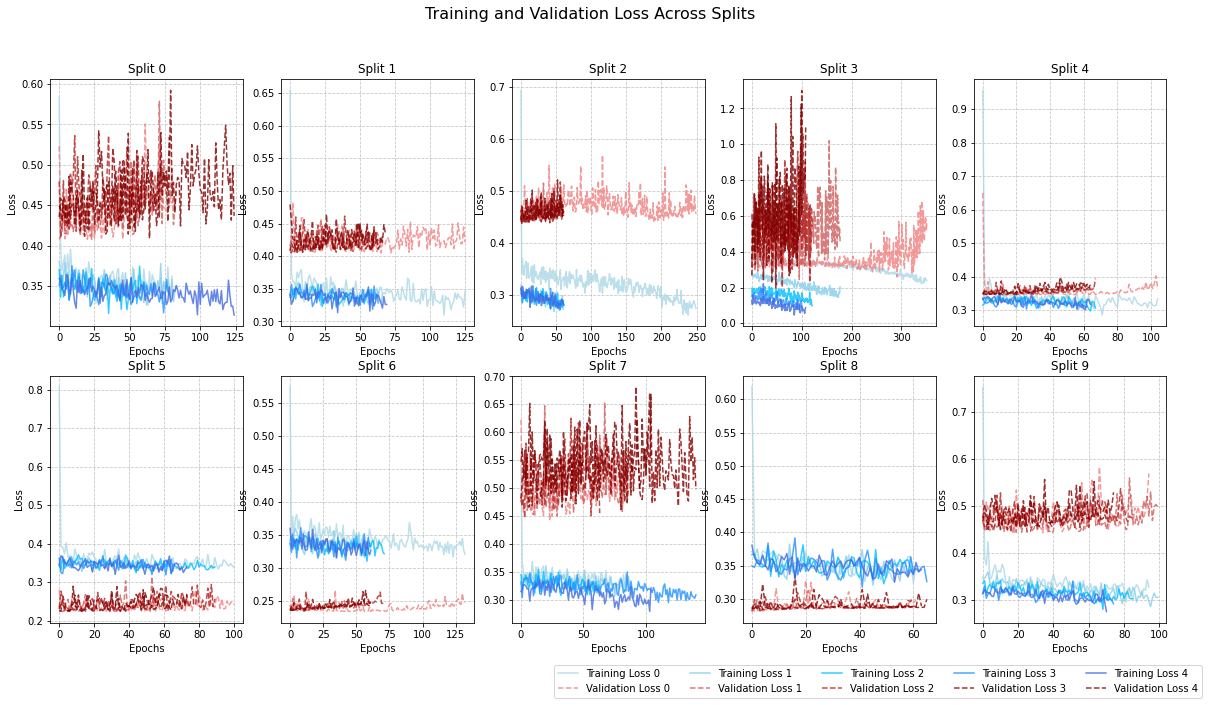

In [28]:
import matplotlib.pyplot as plt
import pickle as pkl

# Create subplots for all 10 splits
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

# Define shades of blue for training loss
train_loss_colors = ['lightblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue']

# Define shades of red for validation loss
val_loss_colors = ['lightcoral', 'indianred', 'firebrick', 'darkred', 'maroon']

for which_split in range(10):
    # Determine subplot indices
    row, col = divmod(which_split, 5)

    # Access the current subplot
    ax = axs[row, col]

    # Iterate over models
    for i in range(5):
        model_name = f"/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/hist_3D_CNN_avg_layer_binary_outcome_CIBLSX_split{which_split}_ens{i}_M5.pkl"
        # Load training history
        with open(model_name, "rb") as file:
            histplt = pkl.load(file)

        # Plot training history lines with different shades of blue for training loss
        ax.plot(histplt['loss'], label=f"Training Loss {i}", color=train_loss_colors[i], linestyle='-', alpha=0.8)
        
        # Plot validation history lines with different shades of red for validation loss
        ax.plot(histplt['val_loss'], label=f"Validation Loss {i}", color=val_loss_colors[i], linestyle='--', alpha=0.8)

    # Set plot labels and title for each subplot
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Split {which_split}")

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

# Add a title for the entire graph
fig.suptitle("Training and Validation Loss Across Splits", fontsize=16)

# Add legend to the last subplot with adjusted location and layout
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.15), fancybox=True, ncol=5)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()